# Convert Single Graph to function

## Preliminaries

### Imports

In [1]:
import os
import sys
import networkx as nx

from os.path import dirname
from networkx.drawing.nx_pydot import to_pydot

note_dir = os.getcwd()

root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import morpheus
from morpheus.tests import default_chain, default_ensemble
from morpheus.graph import (model_to_graph,
                            model_graph_traces,
                            model_graph_layout, 
                            convert_positions_to_dot_format,
                            add_merge_nodes)

### Methods

In [2]:
def fix_layout(G):
    
    for n in G.nodes():
        node = G.nodes(data=True)[n]
        if node['bipartite'] == 'func':
            node['shape'] = "\"square\""
            node['width'] = "2"
        elif node['bipartite'] == 'data':
            node['shape'] = "\"circle\""
        else:
            pass
    
    return G

### Demo graph

In [3]:
ens = default_ensemble()


        Learning model with desc ids:    [0, 1, 2]
                            targ ids:    [5]
        

        Learning model with desc ids:    [0, 1, 3]
                            targ ids:    [4, 5]
        


In [4]:
ens.pretty_print()


        # Main
        Descriptive attributes:     [0. 1. 2. 3.]
        Target attributes:          [4. 5.]

        ## On types (mostly nominals)
        Target attribute types:                     ['numeric', 'numeric']
        N_classes of nominal target attributes:     []
        Classes of nominal target attributes:       []

        ## Weights
        Total weights of target attributes:         [1. 2.]

         
        ## Estimators
        Estimators used:        ['RandomForestRegressor', 'RandomForestRegressor']
        N_estimators:           2
        


In [5]:
model_one = ens.estimators_[0]
model_two = ens.estimators_[1]

In [6]:
G = model_to_graph(model_one, idx=1)

In [7]:
G = fix_layout(G)

In [8]:
G.nodes(data=True)

NodeDataView({'d-00': {'bipartite': 'data', 'kind': 'data', 'idx': 0, 'shape': '"circle"'}, 'd-01': {'bipartite': 'data', 'kind': 'data', 'idx': 1, 'shape': '"circle"'}, 'd-02': {'bipartite': 'data', 'kind': 'data', 'idx': 2, 'shape': '"circle"'}, 'd-05': {'bipartite': 'data', 'kind': 'data', 'idx': 5, 'shape': '"circle"'}, 'f-01': {'bipartite': 'func', 'kind': 'model', 'idx': 1, 'mod': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False), 'function': <bound method ForestRegressor.predict of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_sp

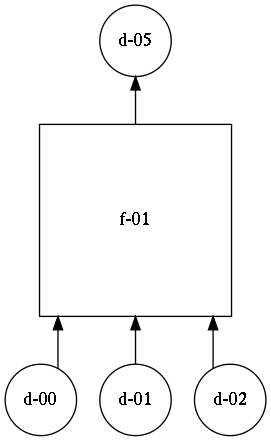

In [9]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

## Parse graph

In [10]:
G.in_degree()

InDegreeView({'d-00': 0, 'd-01': 0, 'd-02': 0, 'd-05': 1, 'f-01': 3})

In [11]:
source_nodes = [node for node, in_degree in G.in_degree() if in_degree == 0]
target_nodes = [node for node, out_degree in G.out_degree() if out_degree == 0]

for n in source_nodes:
    G.nodes()[n]['stage'] = 0

In [12]:
target_nodes

['d-05']

In [13]:
nx.ancestors(G, 'd-01')

set()

In [14]:
list(nx.topological_sort(G))

['d-02', 'd-01', 'd-00', 'f-01', 'd-05']

In [15]:
def select(idx):
    
    def select(X):
        return X[:, idx]
    return select

In [16]:
import numpy as np

In [17]:
X = np.random.randint(0,10, (20, 5))
X

array([[1, 6, 0, 5, 5],
       [1, 7, 4, 6, 7],
       [3, 0, 8, 6, 4],
       [5, 3, 4, 0, 6],
       [1, 4, 5, 4, 2],
       [4, 3, 3, 4, 5],
       [4, 1, 3, 1, 1],
       [1, 9, 8, 2, 1],
       [1, 0, 7, 7, 3],
       [1, 7, 4, 1, 1],
       [4, 7, 8, 2, 6],
       [9, 6, 6, 5, 0],
       [5, 5, 4, 8, 5],
       [3, 2, 3, 6, 9],
       [1, 9, 6, 2, 3],
       [1, 3, 3, 2, 1],
       [4, 1, 7, 4, 5],
       [6, 6, 1, 2, 3],
       [4, 9, 0, 4, 3],
       [0, 9, 4, 2, 5]])

In [18]:
select(4)(X)

array([5, 7, 4, 6, 2, 5, 1, 1, 3, 1, 6, 0, 5, 9, 3, 1, 5, 3, 3, 5])

In [19]:
from functools import reduce

In [20]:
def f1(x):
    return x*2

def f2(x):
    return x+2

def f3(x):
    return x+6

In [21]:
def x(*functions):
    
    def parallel_comp(*function_inputs):
        if len(function_inputs) == 1:
            res = tuple([f(function_inputs[0]) for f in functions])
            return res
        elif len(function_inputs) == len(functions):
            res = tuple([f(x) for f, x in zip(functions, function_inputs)])
            return res
            
    return parallel_comp

In [22]:
px = reduce(x, [f1,f2,f3])

In [23]:
px = x(f1,f2,f3)
px(4)

(8, 6, 10)

In [24]:
px(4,4,4)

(8, 6, 10)

In [25]:
px(4,10,10)

(8, 12, 16)

In [26]:
px(4)

(8, 6, 10)

In [27]:
select(2)(X).shape

(20,)

In [28]:
def o(f1, f2):
    def sequential_composition(*function_arguments):
        return f1(f2(*function_arguments))

    return sequential_composition


def x(*functions, return_type=tuple):
    def parallel_composition(*function_arguments):
        if len(function_arguments) == 1:
            res = return_type([f(function_arguments[0]) for f in functions])
            return res
        elif len(function_arguments) == len(functions):
            res = return_type([f(x) for f, x in zip(functions, function_arguments)])
            return res

    return parallel_composition

In [29]:
pc = o(np.transpose, x(select(1), select(2), select(3), return_type=np.array))

In [30]:
pc(X)

array([[6, 0, 5],
       [7, 4, 6],
       [0, 8, 6],
       [3, 4, 0],
       [4, 5, 4],
       [3, 3, 4],
       [1, 3, 1],
       [9, 8, 2],
       [0, 7, 7],
       [7, 4, 1],
       [7, 8, 2],
       [6, 6, 5],
       [5, 4, 8],
       [2, 3, 6],
       [9, 6, 2],
       [3, 3, 2],
       [1, 7, 4],
       [6, 1, 2],
       [9, 0, 4],
       [9, 4, 2]])

In [31]:
np.array(pc(X))

array([[6, 0, 5],
       [7, 4, 6],
       [0, 8, 6],
       [3, 4, 0],
       [4, 5, 4],
       [3, 3, 4],
       [1, 3, 1],
       [9, 8, 2],
       [0, 7, 7],
       [7, 4, 1],
       [7, 8, 2],
       [6, 6, 5],
       [5, 4, 8],
       [2, 3, 6],
       [9, 6, 2],
       [3, 3, 2],
       [1, 7, 4],
       [6, 1, 2],
       [9, 0, 4],
       [9, 4, 2]])

In [32]:
def build_array(array_tuple):
    n_rows = np.unique([t.shape[0] for t in array_tuple])
    return n_rows

In [33]:
build_array(pc(X))

array([3])

In [34]:
sorted_list = list(nx.topological_sort(G))
print(sorted_list)
functions = {}
for node_name in sorted_list:
    node = G.nodes(data=True)[node_name]
    
    if node['bipartite'] == 'data': 
        if len(nx.ancestors(G, node_name)) == 0:
            functions[node_name] = select(node['idx'])
        elif len(nx.descendants(G, node_name)) == 0:
            functions[node_name] = 'end'
            
    elif node['bipartite'] == 'func':
        inputs = [functions[n] for n in nx.ancestors(G, node_name)]
        inputs = o(np.transpose, x(*inputs, return_type=np.array))
        f = node['function']
        functions[node_name] = o(f, inputs)
        
        
        

['d-02', 'd-01', 'd-00', 'f-01', 'd-05']


In [35]:
functions

{'d-02': <function __main__.select.<locals>.select(X)>,
 'd-01': <function __main__.select.<locals>.select(X)>,
 'd-00': <function __main__.select.<locals>.select(X)>,
 'f-01': <function __main__.o.<locals>.sequential_composition(*function_arguments)>,
 'd-05': 'end'}

In [36]:
X[:, 0:3]

array([[1, 6, 0],
       [1, 7, 4],
       [3, 0, 8],
       [5, 3, 4],
       [1, 4, 5],
       [4, 3, 3],
       [4, 1, 3],
       [1, 9, 8],
       [1, 0, 7],
       [1, 7, 4],
       [4, 7, 8],
       [9, 6, 6],
       [5, 5, 4],
       [3, 2, 3],
       [1, 9, 6],
       [1, 3, 3],
       [4, 1, 7],
       [6, 6, 1],
       [4, 9, 0],
       [0, 9, 4]])

In [38]:
functions['f-01'](X)

array([ 2.94791294, -0.43249556, -1.22018713,  0.25375032, -0.43249556,
        2.2528195 ,  0.25280783, -0.43249556, -1.09925517, -0.43249556,
       -0.43249556, -0.43249556, -0.43249556,  1.12706528, -0.43249556,
        2.2528195 , -0.26582987,  2.94791294,  2.94791294, -0.43249556])